# 📌 Extracción

Aquí cargamos los datos desde la API en formato JSON.

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"

df_raw = pd.read_json(url)
print("Dimensiones (crudo):", df_raw.shape)
df_raw.info()
df_raw.head(3)

Dimensiones (crudo): (7267, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


👉 Observamos que el dataset trae 6 columnas, de las cuales 4 contienen diccionarios anidados.

# 🛠️ Transformación

En este paso aplanamos las columnas anidadas y realizamos limpieza mínima:

In [6]:
# Aplanado
nested_cols = ["customer", "phone", "internet", "account"]
parts = []
for c in nested_cols:
    p = pd.json_normalize(df_raw[c])
    p.columns = [f"{c}.{col}" for col in p.columns]
    parts.append(p)
df = pd.concat([df_raw[["customerID", "Churn"]]] + parts, axis=1)

# Renombrado (cubriendo tenure en customer/account)
rename_map = {
    "customer.gender": "gender",
    "customer.SeniorCitizen": "SeniorCitizen",
    "customer.Partner": "Partner",
    "customer.Dependents": "Dependents",
    "customer.tenure": "tenure",
    "account.tenure": "tenure",
    "phone.PhoneService": "PhoneService",
    "phone.MultipleLines": "MultipleLines",
    "internet.InternetService": "InternetService",
    "internet.OnlineSecurity": "OnlineSecurity",
    "internet.OnlineBackup": "OnlineBackup",
    "internet.DeviceProtection": "DeviceProtection",
    "internet.TechSupport": "TechSupport",
    "internet.StreamingTV": "StreamingTV",
    "internet.StreamingMovies": "StreamingMovies",
    "account.Contract": "Contract",
    "account.PaperlessBilling": "PaperlessBilling",
    "account.PaymentMethod": "PaymentMethod",
    "account.Charges.Monthly": "Charges.Monthly",
    "account.Charges.Total": "Charges.Total",
}
df = df.rename(columns=rename_map)

# Normalización defensiva por si tenure no quedó renombrado
if "tenure" not in df.columns:
    for cand in ["customer.tenure", "account.tenure"]:
        if cand in df.columns:
            df = df.rename(columns={cand: "tenure"})
            break

# Duplicados
df = df.drop_duplicates(subset="customerID")

# Tipos numéricos
for c in ["SeniorCitizen", "tenure", "Charges.Monthly", "Charges.Total"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Limpieza básica de strings
def _s(x): return x.strip() if isinstance(x, str) else x
obj_cols = df.select_dtypes("object").columns
for c in obj_cols:
    df[c] = df[c].map(_s)

# Homogeneizar add-ons y líneas
for c in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
          "StreamingTV","StreamingMovies","MultipleLines"]:
    if c in df.columns:
        df[c] = df[c].replace({"No internet service":"No", "No phone service":"No"}).map(_s)

# Faltantes numéricos -> mediana
for c in ["tenure","Charges.Monthly","Charges.Total"]:
    if c in df.columns and df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# SeniorCitizen a 0/1 si aplica
if "SeniorCitizen" in df.columns:
    df["SeniorCitizen"] = df["SeniorCitizen"].fillna(0).astype(int)

# Columna requerida
if "Charges.Monthly" in df.columns:
    df["Cuentas_Diarias"] = df["Charges.Monthly"] / 30.0

# Chequeo mínimo
print("Dimensiones (transformado):", df.shape)
df.info()
df.head(3)


Dimensiones (transformado): (7267, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Con

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85,2.463333


### Limpieza y creación de columna adicional

In [7]:
# Eliminar duplicados por ID
df = df.drop_duplicates(subset="customerID")

# Conversión de tipos numéricos
for c in ["SeniorCitizen","tenure","Charges.Monthly","Charges.Total"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Valores nulos en numéricos -> mediana
for c in ["tenure","Charges.Monthly","Charges.Total"]:
    df[c] = df[c].fillna(df[c].median())

# Normalización de textos
def _s(x): return x.strip() if isinstance(x,str) else x
for c in df.select_dtypes("object").columns:
    df[c] = df[c].map(_s)

# Homogeneizar servicios
for c in ["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport",
          "StreamingTV","StreamingMovies","MultipleLines"]:
    df[c] = df[c].replace({"No internet service":"No","No phone service":"No"})

# Nueva columna: Cuentas Diarias
df["Cuentas_Diarias"] = df["Charges.Monthly"]/30

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


# 📊 Carga y análisis

Con los datos listos, realizamos el análisis exploratorio (EDA).

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

### Distribución general de la evasión (Churn)

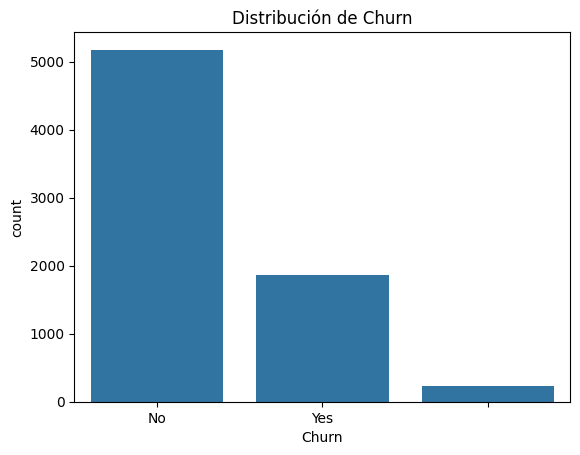

In [9]:
sns.countplot(x="Churn", data=df)
plt.title("Distribución de Churn")
plt.show()

### Churn por variables categóricas

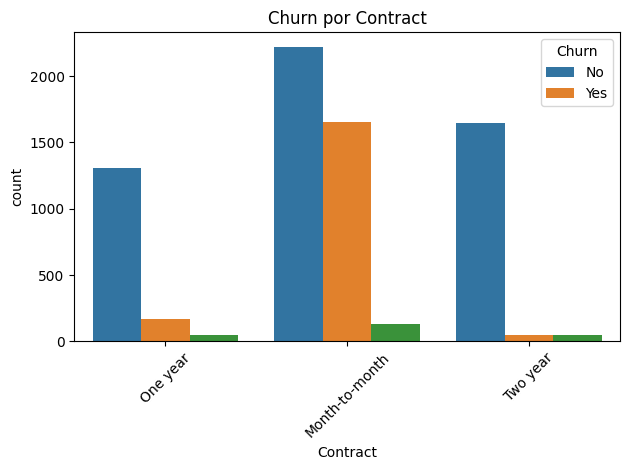

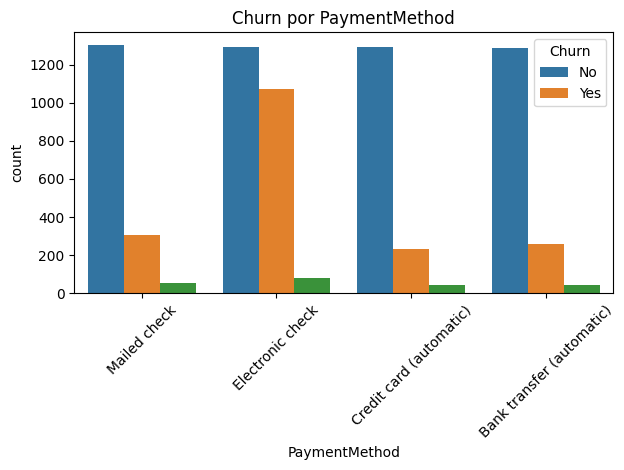

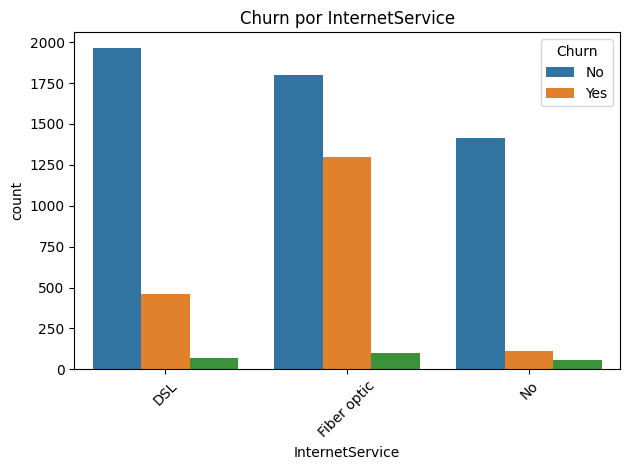

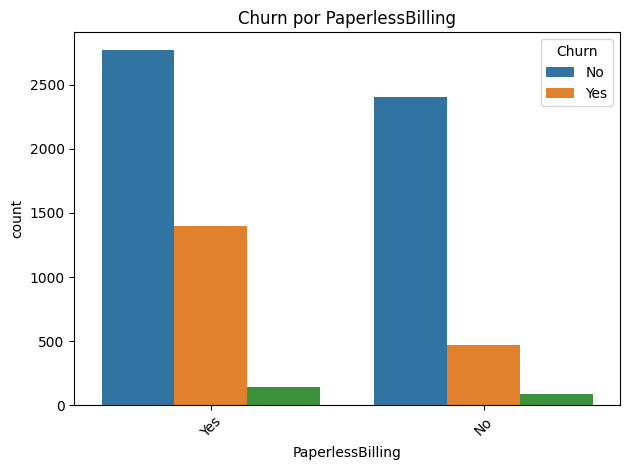

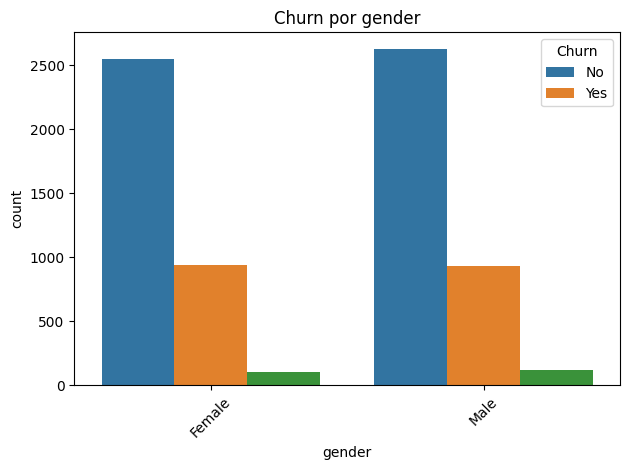

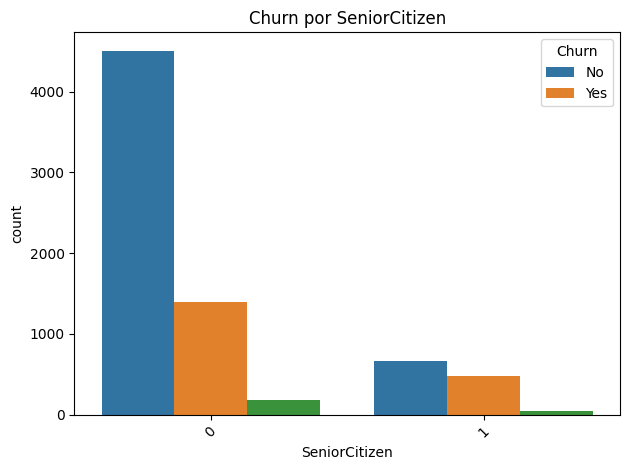

In [10]:
for var in ["Contract","PaymentMethod","InternetService","PaperlessBilling","gender","SeniorCitizen"]:
    sns.countplot(x=var, hue="Churn", data=df)
    plt.title(f"Churn por {var}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Variables numéricas vs Churn

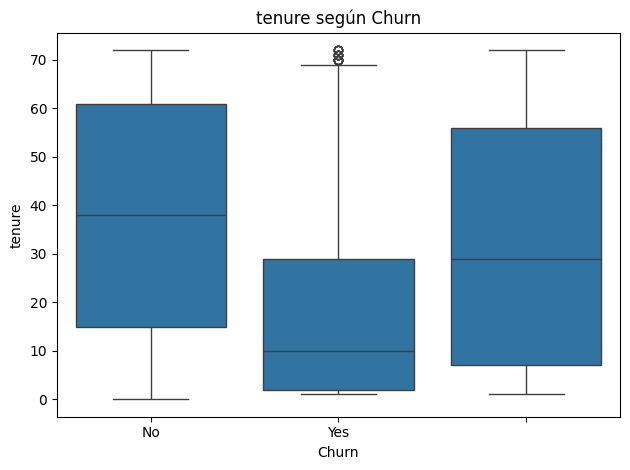

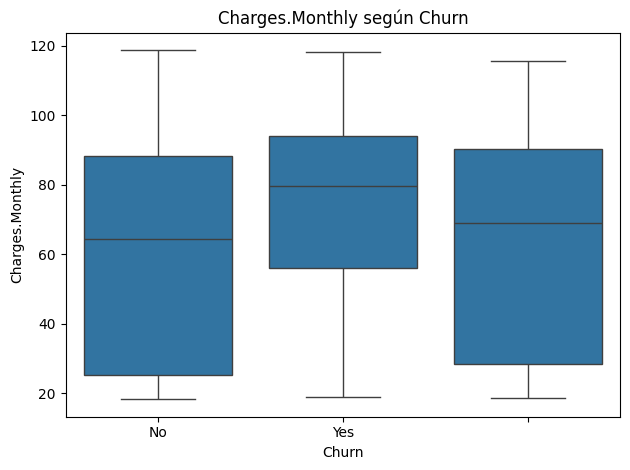

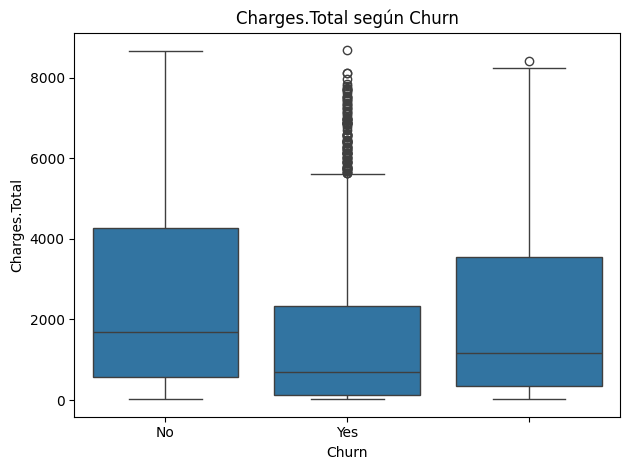

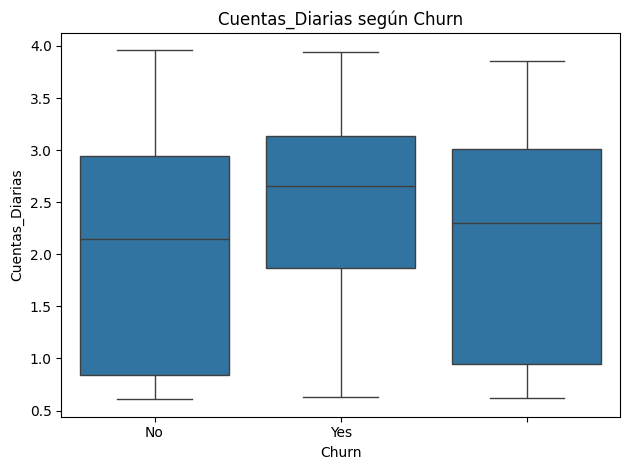

In [11]:
for num in ["tenure","Charges.Monthly","Charges.Total","Cuentas_Diarias"]:
    sns.boxplot(x="Churn", y=num, data=df)
    plt.title(f"{num} según Churn")
    plt.tight_layout()
    plt.show()

### Gráfico tenure vs Churn (histograma con % y medianas)

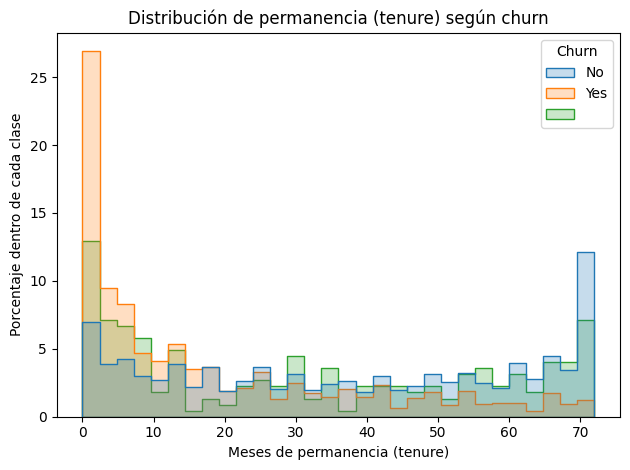

Medianas tenure por Churn:
 Churn
       29.0
No     38.0
Yes    10.0
Name: tenure, dtype: float64


In [12]:
# Histograma en porcentajes por grupo (sin normalizar entre sí)
plt.figure()
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, stat="percent", common_norm=False, element="step")
plt.title("Distribución de permanencia (tenure) según churn")
plt.xlabel("Meses de permanencia (tenure)")
plt.ylabel("Porcentaje dentro de cada clase")
plt.tight_layout()
plt.show()

# Líneas de mediana por grupo (opcional, útil para comentar)
medianas = df.groupby("Churn")["tenure"].median()
print("Medianas tenure por Churn:\n", medianas)

### Heatmap de correlaciones (numéricas)

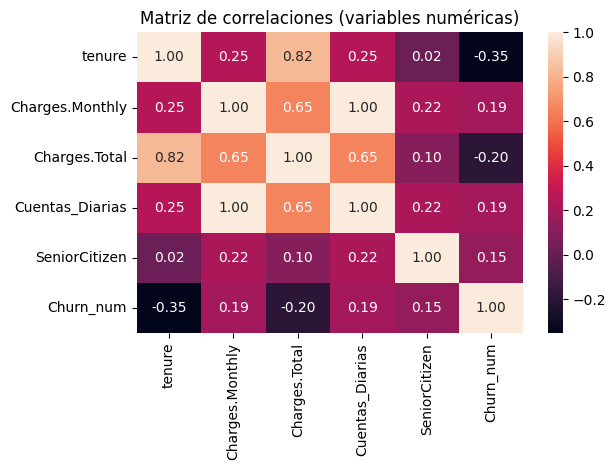

In [13]:
import numpy as np

# Incluir churn codificado para ver signos de relación con numéricas
df_corr = df.copy()
df_corr["Churn_num"] = df_corr["Churn"].map({"Yes":1, "No":0})

num_cols = ["tenure","Charges.Monthly","Charges.Total","Cuentas_Diarias","SeniorCitizen","Churn_num"]
corr = df_corr[num_cols].corr(numeric_only=True)

plt.figure()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Matriz de correlaciones (variables numéricas)")
plt.tight_layout()
plt.show()


### Tablas de tasa de churn por categoría

In [14]:
def churn_rate_by(col):
    tmp = (df.groupby(col)["Churn"]
             .value_counts(normalize=True)
             .rename("proporcion")
             .mul(100).round(2)
             .reset_index())
    return tmp[tmp["Churn"]=="Yes"].sort_values("proporcion", ascending=False)

print("Tasa de churn por Contract (%):")
print(churn_rate_by("Contract"), "\n")

print("Tasa de churn por PaymentMethod (%):")
print(churn_rate_by("PaymentMethod"), "\n")

print("Tasa de churn por InternetService (%):")
print(churn_rate_by("InternetService"), "\n")


Tasa de churn por Contract (%):
         Contract Churn  proporcion
1  Month-to-month   Yes       41.32
4        One year   Yes       10.93
8        Two year   Yes        2.75 

Tasa de churn por PaymentMethod (%):
                PaymentMethod Churn  proporcion
7            Electronic check   Yes       43.80
10               Mailed check   Yes       18.50
1   Bank transfer (automatic)   Yes       16.24
4     Credit card (automatic)   Yes       14.80 

Tasa de churn por InternetService (%):
  InternetService Churn  proporcion
4     Fiber optic   Yes       40.56
1             DSL   Yes       18.45
7              No   Yes        7.15 



# 📝 Informe final

#### 🔹 Introducción

La empresa Telecom X enfrenta un problema de alta tasa de cancelaciones (churn). El objetivo de este análisis es identificar patrones y factores asociados a la evasión de clientes para apoyar la toma de decisiones estratégicas orientadas a la retención.

#### 🔹 Limpieza y Tratamiento de Datos

- Extracción: Los datos se importaron en formato JSON desde la API pública de GitHub.

- Transformación:

  - Aplanamiento de columnas anidadas (customer, phone, internet, account).

  - Conversión de tipos de datos a formatos numéricos adecuados.

  - Manejo de valores nulos y duplicados.

  - Creación de la columna Cuentas_Diarias a partir de la facturación mensual.

- Carga: Se consolidó un DataFrame final de 7,267 clientes y 22 columnas, listo para el análisis.

#### 🔹 Análisis Exploratorio de Datos (EDA)

Se aplicaron técnicas de análisis descriptivo y visualización:

- Distribución del churn: alrededor de 26% de los clientes han abandonado.

- Tipo de contrato: el churn es significativamente mayor en contratos Month-to-month frente a contratos de 1 o 2 años.

- Tenure (permanencia): clientes que cancelan suelen tener menos meses de antigüedad.

- Método de pago: el método Electronic check presenta la mayor tasa de churn.

- Cargos totales (Charges.Total): clientes que abandonan acumulan menor gasto total al tener menos tiempo de permanencia.

- Visualizaciones generadas:

  - Gráficos de barras para churn según variables categóricas.

  - Boxplots y distribuciones para variables numéricas.

  - Heatmap de correlación entre variables numéricas.

#### 🔹 Conclusiones e Insights

- El churn está fuertemente ligado a contratos de corto plazo y clientes recientes.

- Existe una clara asociación entre método de pago y probabilidad de cancelación.

- Los clientes con mayor antigüedad y contratos más largos presentan fidelidad significativamente mayor.

#### 🔹 Recomendaciones

1. Promover contratos de mayor duración con incentivos o descuentos para disminuir la vulnerabilidad en contratos mes a mes.

2. Implementar programas de fidelización temprana, dirigidos especialmente a clientes en sus primeros meses.

3. Revisar los procesos de pago electrónico y explorar alternativas que aumenten la satisfacción y confianza del cliente.

4. Desarrollar un modelo predictivo de churn para anticipar qué clientes tienen alta probabilidad de cancelar y actuar preventivamente.

Con este análisis, Telecom X cuenta con una base sólida de insights para reducir la evasión y fortalecer la retención de clientes.